In [84]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import  GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import category_encoders as ce


# Check for GPU availability
try:
    import torch
    GPU_AVAILABLE = torch.cuda.is_available()
    # GPU_AVAILABLE=False
    print(f"GPU Available: {GPU_AVAILABLE}")
except ImportError:
    GPU_AVAILABLE = False
    print("PyTorch not installed; assuming no GPU support.")

# GPU-Compatible Libraries
if GPU_AVAILABLE:
    from cuml.ensemble import RandomForestRegressor
    from cuml.svm import SVR
    from xgboost import XGBRegressor
    from lightgbm import LGBMRegressor
    from cuml.preprocessing import PolynomialFeatures
    from cuml.linear_model import LinearRegression
    from cuml.preprocessing import StandardScaler, OneHotEncoder
    
    print("Using GPU-accelerated libraries.")
else:
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.svm import SVR
    from xgboost import XGBRegressor
    from lightgbm import LGBMRegressor
    from sklearn.preprocessing import StandardScaler, OneHotEncoder
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.linear_model import LinearRegression
   
    import sklearn
    # from sklearn.model_selection import train_test_split
    print("Using CPU-based libraries.")



GPU Available: True
Using GPU-accelerated libraries.


In [85]:
# pip install --upgruad scikit-learn
import platform
print(platform.python_version())


3.10.12


In [88]:
# Load the data
file_path = '/kaggle/input/data-property-v5/Egypt_Houses_Price_Cleaned.csv'  # Update the path if needed
df = pd.read_csv(file_path)  


In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20591 entries, 0 to 20590
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Type            20591 non-null  object 
 1   Price           20591 non-null  float64
 2   Bedrooms        20591 non-null  float64
 3   Bathrooms       20591 non-null  float64
 4   Area            20591 non-null  float64
 5   Furnished       20591 non-null  object 
 6   Level           20591 non-null  float64
 7   Compound        20591 non-null  object 
 8   Payment_Option  20591 non-null  object 
 9   Delivery_Date   20591 non-null  float64
 10  Delivery_Term   20591 non-null  object 
 11  City            20591 non-null  object 
 12  Price_Category  20591 non-null  object 
 13  Area_Category   20591 non-null  object 
 14  Price_per_sqm   20591 non-null  float64
 15  in_Compound     20591 non-null  int64  
 16  Immediate_Move  20591 non-null  int64  
dtypes: float64(7), int64(2), object

In [90]:
df.nunique()

Type                 7
Price             3429
Bedrooms             8
Bathrooms            8
Area               726
Furnished            3
Level               17
Compound           539
Payment_Option       4
Delivery_Date       19
Delivery_Term        5
City               175
Price_Category       6
Area_Category        4
Price_per_sqm     9265
in_Compound          2
Immediate_Move       2
dtype: int64

In [91]:
df.head()


,Type,Price,Bedrooms,Bathrooms,Area,Furnished,Level,Compound,Payment_Option,Delivery_Date,Delivery_Term,City,Price_Category,Area_Category,Price_per_sqm,in_Compound,Immediate_Move
0,Duplex,4000000.0,3.0,3.0,400.0,No,7.0,Unknown,Cash,0.0,Finished,Nasr City,Premium,Very Large,10000.000000,0,1
1,Apartment,4000000.0,3.0,3.0,160.0,No,10.0,Unknown,Cash,0.0,Finished,Camp Caesar,Premium,Medium,25000.000000,0,1
2,Apartment,2250000.0,3.0,2.0,165.0,No,1.0,Unknown,Cash,0.0,Finished,Smoha,Premium,Large,13636.363636,0,1
3,Apartment,1900000.0,3.0,2.0,230.0,No,10.0,Unknown,Cash,0.0,Finished,Nasr City,Premium,Large,8260.869565,0,1
4,Apartment,1844900.0,4.0,3.0,222.0,No,1.0,Beit Al Watan,Cash or Installment,36.0,Semi Finished,New Cairo - El Tagamoa,Premium,Large,8310.360360,1,0


In [92]:
# df=df.drop(['Unnamed: 0','price'],axis=1)
df=df.drop(["Price_Category","Price_per_sqm","Area_Category","in_Compound","Immediate_Move"],axis=1)

In [93]:
df.isnull().sum()

Type              0
Price             0
Bedrooms          0
Bathrooms         0
Area              0
Furnished         0
Level             0
Compound          0
Payment_Option    0
Delivery_Date     0
Delivery_Term     0
City              0
dtype: int64

In [95]:

# Create new features

# df["Price_per_sqm"] = df["Price"] / df["Area"]
# df["Furnished"] = df["Furnished"].map({"Yes": 1, "No": 0})
# df["Compound"] = df["Compound"].apply(lambda x: 0 if str(x).lower() == "unknown" else 1)
# df["Immediate_Move"] = df["Delivery_Date"].apply(lambda x: 1 if x == 0 else 0)

# # One-hot encoding for categorical features
# categorical_features = ["Type", "Payment_Option", "Delivery_Term", "City"]
# df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

# Feature interactions
# df["Bedrooms_Bathrooms"] = df["Bedrooms"] * df["Bathrooms"]
# df["Level_Area"] = df["Level"] * df["Area"]
# df["RationBathrooms_to_Bedrooms"] = df["Bedrooms"] / df["Bathrooms"]


# Log transformation
df["Log_Price"] = np.log1p(df["Price"])


# Feature Engineering
# df["Level_Area"] = df["Level"] * df["Area"]
# df["Area_per_Bedroom"] = df["Area"] / df["Bedrooms"].replace(0, np.nan)
# df["Area_per_Bathroom"] = df["Area"] / df["Bathrooms"].replace(0, np.nan)



In [97]:
df.head()

,Type,Price,Bedrooms,Bathrooms,Area,Furnished,Level,Compound,Payment_Option,Delivery_Date,Delivery_Term,City,Log_Price
0,Duplex,4000000.0,3.0,3.0,400.0,No,7.0,Unknown,Cash,0.0,Finished,Nasr City,15.201805
1,Apartment,4000000.0,3.0,3.0,160.0,No,10.0,Unknown,Cash,0.0,Finished,Camp Caesar,15.201805
2,Apartment,2250000.0,3.0,2.0,165.0,No,1.0,Unknown,Cash,0.0,Finished,Smoha,14.626441
3,Apartment,1900000.0,3.0,2.0,230.0,No,10.0,Unknown,Cash,0.0,Finished,Nasr City,14.457365
4,Apartment,1844900.0,4.0,3.0,222.0,No,1.0,Beit Al Watan,Cash or Installment,36.0,Semi Finished,New Cairo - El Tagamoa,14.427936


In [101]:
df.columns

Index(['Type', 'Price', 'Bedrooms', 'Bathrooms', 'Area', 'Furnished', 'Level',
       'Compound', 'Payment_Option', 'Delivery_Date', 'Delivery_Term', 'City',
       'Log_Price'],
      dtype='object')

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20591 entries, 0 to 20590
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Type            20591 non-null  object 
 1   Price           20591 non-null  float64
 2   Bedrooms        20591 non-null  float64
 3   Bathrooms       20591 non-null  float64
 4   Area            20591 non-null  float64
 5   Furnished       20591 non-null  object 
 6   Level           20591 non-null  float64
 7   Compound        20591 non-null  object 
 8   Payment_Option  20591 non-null  object 
 9   Delivery_Date   20591 non-null  float64
 10  Delivery_Term   20591 non-null  object 
 11  City            20591 non-null  object 
 12  Log_Price       20591 non-null  float64
dtypes: float64(7), object(6)
memory usage: 2.0+ MB


In [103]:
# Define features and target
target_column="Price"
X = df.drop(columns=[target_column,"Log_Price"])  

y = df["Log_Price"].astype("float32")  

In [104]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [105]:
# Define preprocessing steps
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

In [106]:
from sklearn.base import BaseEstimator, TransformerMixin



In [107]:
# Custom Transformer to Convert Output to Float32
class Float32Transformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.astype('float32')
    
    


In [108]:

#Define preprocessing for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
   
])


# Ensure the data passed to cuML's encoder is a pandas DataFrame
from sklearn.preprocessing import FunctionTransformer

# This function makes sure the output is a pandas DataFrame
def ensure_dataframe(X):
    return pd.DataFrame(X)

ensure_dataframe_transformer = FunctionTransformer(ensure_dataframe)



# categorical_transformer = Pipeline(steps=[
#     ("imputer", SimpleImputer(strategy="most_frequent"))
#     ,("to_dataframe",ensure_dataframe_transformer)
    
#     ,("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    
    
# ])


#  Combine preprocessors in a ColumnTransformer

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numerical_transformer, numeric_features)
#        ,('cat', categorical_transformer, categorical_features)
#     ]
# )




In [110]:
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent"))
    ,("binary_encode", ce.BinaryEncoder())
    
    
])



# Combine preprocessors in a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
         ("cat",categorical_transformer,categorical_features)
        ,('num', numerical_transformer, numeric_features)
    ]
)


In [111]:
preprocessor

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('binary_encode',
                                                  BinaryEncoder())]),
                                 Index(['Type', 'Furnished', 'Compound', 'Payment_Option', 'Delivery_Term',
       'City'],
      dtype='object')),
                                ('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 Index(['Bedrooms', 'Bathrooms', 'Area', 'Level', 'Delivery_Date'], dtype='object'))])

In [112]:
# print(pipeline_RandomForest.steps)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20591 entries, 0 to 20590
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Type            20591 non-null  object 
 1   Bedrooms        20591 non-null  float64
 2   Bathrooms       20591 non-null  float64
 3   Area            20591 non-null  float64
 4   Furnished       20591 non-null  object 
 5   Level           20591 non-null  float64
 6   Compound        20591 non-null  object 
 7   Payment_Option  20591 non-null  object 
 8   Delivery_Date   20591 non-null  float64
 9   Delivery_Term   20591 non-null  object 
 10  City            20591 non-null  object 
dtypes: float64(5), object(6)
memory usage: 1.7+ MB


In [113]:
preprocessor.fit_transform(X_train)

array([[ 0.        ,  0.        ,  1.        , ..., -0.7438756 ,
        -0.71561294, -0.29751831],
       [ 0.        ,  1.        ,  0.        , ...,  0.41070453,
        -0.71561294,  1.81846851],
       [ 0.        ,  1.        ,  1.        , ..., -0.23431231,
        -0.24450561,  1.81846851],
       ...,
       [ 1.        ,  1.        ,  0.        , ..., -0.20206147,
         0.22660171,  3.35736801],
       [ 0.        ,  1.        ,  1.        , ...,  0.53970789,
         0.22660171, -0.48988075],
       [ 0.        ,  1.        ,  0.        , ...,  1.62333617,
        -0.71561294, -0.48988075]])

In [114]:
df.head()

,Type,Price,Bedrooms,Bathrooms,Area,Furnished,Level,Compound,Payment_Option,Delivery_Date,Delivery_Term,City,Log_Price
0,Duplex,4000000.0,3.0,3.0,400.0,No,7.0,Unknown,Cash,0.0,Finished,Nasr City,15.201805
1,Apartment,4000000.0,3.0,3.0,160.0,No,10.0,Unknown,Cash,0.0,Finished,Camp Caesar,15.201805
2,Apartment,2250000.0,3.0,2.0,165.0,No,1.0,Unknown,Cash,0.0,Finished,Smoha,14.626441
3,Apartment,1900000.0,3.0,2.0,230.0,No,10.0,Unknown,Cash,0.0,Finished,Nasr City,14.457365
4,Apartment,1844900.0,4.0,3.0,222.0,No,1.0,Beit Al Watan,Cash or Installment,36.0,Semi Finished,New Cairo - El Tagamoa,14.427936


In [115]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20591 entries, 0 to 20590
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Type            20591 non-null  object 
 1   Bedrooms        20591 non-null  float64
 2   Bathrooms       20591 non-null  float64
 3   Area            20591 non-null  float64
 4   Furnished       20591 non-null  object 
 5   Level           20591 non-null  float64
 6   Compound        20591 non-null  object 
 7   Payment_Option  20591 non-null  object 
 8   Delivery_Date   20591 non-null  float64
 9   Delivery_Term   20591 non-null  object 
 10  City            20591 non-null  object 
dtypes: float64(5), object(6)
memory usage: 1.7+ MB


In [116]:
# X.to_csv('out.csv', index=False)



# Random Forest

In [125]:
# Define the model
if GPU_AVAILABLE:
    model = RandomForestRegressor(n_streams=1,random_state=42)
else :
    model = RandomForestRegressor(random_state=42)

# Create a pipeline that includes preprocessing and the model

pipeline_RandomForest = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('to_float32', Float32Transformer()),
    ('model', model)
])


# Define hyperparameter grid for model tuning
param_grid = {
    'model__n_estimators': [100,200,300,400]
     ,
    'model__max_depth': [ 30,40,50,60],
   'model__min_samples_split': [5,7, 10,15],
  'model__min_samples_leaf': [1,2,4,6]
}


# param_grid = {
#     'model__n_estimators': [400] 
#      ,
#     'model__max_depth': [30],
#    'model__min_samples_split': [5],
#   'model__min_samples_leaf': [1]
# }







# Use GridSearchCV to find the best parameters  
grid_search = GridSearchCV(pipeline_RandomForest, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=1)

# Fit the pipeline to the training data

    
grid_search.fit(X_train, y_train)

# Evaluate the model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred = y_pred.get() if hasattr(y_pred, 'get') else y_pred

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test R2 Score: {r2:.2f}")










import dill
# Save the best model

with open('/kaggle/working/random_forest_best_model.pkl', 'wb') as f:
    dill.dump(best_model, f)
print("Model saved successfully with dill.")









Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters: {'model__max_depth': 30, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 400}
Test RMSE: 0.70
Test R2 Score: 0.65
Model saved successfully with dill.


In [118]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import dill

# Define PCA transformer
pca = PCA(n_components=0.80)  # Retain 95% of the variance

# Define the model (Random Forest Regressor)
model = RandomForestRegressor(n_streams=1,random_state=42)

# Create a pipeline that includes preprocessing (scaling, PCA) and the model
pipeline_RandomForest = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('to_float32', Float32Transformer()),
    ('pca', pca),                  # Apply PCA for dimensionality reduction
    ('model', model)               # RandomForest model
])

# Define hyperparameter grid for model tuning
param_grid = {
    'model__n_estimators': [100, 200, 300, 400],
    'model__max_depth': [30, 40, 50, 60],
    'model__min_samples_split': [5, 7, 10, 15],
    'model__min_samples_leaf': [1, 2, 4, 6]
}



# param_grid = {
#     'model__n_estimators': [300] 
#      ,
#     'model__max_depth': [30],
#    'model__min_samples_split': [5],
#   'model__min_samples_leaf': [2]
# }



# Use GridSearchCV to find the best parameters
grid_search = GridSearchCV(pipeline_RandomForest, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Fit the pipeline to the training data (replace X_train, y_train with your actual data)
grid_search.fit(X_train, y_train)

# Evaluate the model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Convert predictions if needed (e.g., if using GPU-based libraries like cuML)
y_pred = y_pred.get() if hasattr(y_pred, 'get') else y_pred

# Compute evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test R2 Score: {r2:.2f}")





# Save the best model using dill
with open('/kaggle/working/random_forest_best_model.pkl', 'wb') as f:
    dill.dump(best_model, f)
print("Model saved successfully with dill.")


Fitting 5 folds for each of 256 candidates, totalling 1280 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'model__max_depth': 30, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 300}
Test RMSE: 0.81
Test R2 Score: 0.53
Model saved successfully with dill.


# Support Vector Regressor (SVR)

In [120]:
# from sklearn.svm import SVR

model = SVR()
import cupy
cupy.get_default_memory_pool().free_all_blocks()
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])
# max 17
param_grid = {
    'model__kernel': ['linear', 'rbf', 'poly']
    ,'model__C': [0.1, 1, 10]
    ,'model__epsilon': [0.1, 0.2, 0.5]
}






grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred = y_pred.get() if hasattr(y_pred, 'get') else y_pred



mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test R2 Score: {r2:.2f}")

# Save the best model
with open('/kaggle/working/svr_best_model.pkl', 'wb') as f:
    dill.dump(best_model, f)
print("Model saved successfully with dill.")




Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'model__C': 10, 'model__epsilon': 0.2, 'model__kernel': 'linear'}
Test RMSE: 0.83
Test R2 Score: 0.50
Model saved successfully with dill.


# XGBoost

In [122]:
# Dynamically set the device parameter
device = 'cuda' if GPU_AVAILABLE else 'cpu'


# Define the model
model = XGBRegressor(tree_method='hist', device=device, random_state=42)


pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [3, 5, 7]
}

# max59
# param_grid = {
#     'model__n_estimators': [ 200],
#     'model__learning_rate': [0.1],
#     'model__max_depth': [7]
# }

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred = y_pred.get() if hasattr(y_pred, 'get') else y_pred

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test R2 Score: {r2:.2f}")

# Save the best model
with open('/kaggle/working/xgboost_best_model.pkl', 'wb') as f:
    dill.dump(best_model, f)
print("Model saved successfully with dill.")

# joblib.dump(best_model, '/kaggle/working/xgboost_best_model.pkl')
# print("XGBoost model saved as 'xgboost_best_model.pkl'.")


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 200}
Test RMSE: 0.70
Test R2 Score: 0.65
Model saved successfully with dill.


# LightGBM

In [123]:

model = LGBMRegressor(device='gpu' if GPU_AVAILABLE else 'cpu',random_state=42)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])
# max 59
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [-1, 10, 20]
}
# param_grid = {
#     'model__n_estimators': [200],
#     'model__learning_rate': [0.2],
#     'model__max_depth': [10]
# }

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred = y_pred.get() if hasattr(y_pred, 'get') else y_pred

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test R2 Score: {r2:.2f}")

# Save the best model
with open('/kaggle/working/lightgbm_best_model.pkl', 'wb') as f:
    dill.dump(best_model, f)
print("Model saved successfully with dill.")





Fitting 5 folds for each of 27 candidates, totalling 135 fits
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 360
[LightGBM] [Info] Number of data points in the train set: 16472, number of used features: 33
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 12 dense feature groups (0.19 MB) transferred to GPU in 0.001345 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 14.539200
Best Parameters: {'model__learning_rate': 0.2, 'model__max_depth': 10, 'model__n_estimators': 200}
Test RMSE: 0.70
Test R2 Score: 0.65
Model saved successfully with dill.


# Linear Regression

In [124]:
# Define the model as Linear Regression
model_poly = LinearRegression()

# Create a pipeline that includes PolynomialFeatures, preprocessing, and the model
pipeline_poly = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('poly_features', PolynomialFeatures()),  # Polynomial features step
    ('to_float32', Float32Transformer()),
    ('model', model_poly)
])

# Define hyperparameter grid for tuning
param_grid = {
    'poly_features__degree': [1,2,3,4,5]  # Degree of polynomial features
}



# GridSearchCV to find the best parameters
grid_search_poly = GridSearchCV(pipeline_poly, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)


# Fit the pipeline to the training data
grid_search_poly.fit(X_train, y_train)

# Evaluate the model on the test set
best_model_poly = grid_search_poly.best_estimator_
y_pred_poly = best_model_poly.predict(X_test)
y_pred_poly = y_pred_poly.get() if hasattr(y_pred_poly, 'get') else y_pred_poly

mse_poly = mean_squared_error(y_test, y_pred_poly)
rmse_poly = np.sqrt(mse_poly)
r2_poly = r2_score(y_test, y_pred_poly)

print(f"Best Parameters for Polynomial Regression: {grid_search_poly.best_params_}")
print(f"Test RMSE: {rmse_poly:.2f}")
print(f"Test R2 Score: {r2_poly:.2f}")

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 23.08, the new 'copy_X' parameter defaults to 'True', ensuring a copy of X is created after passing it to fit(), preventing any changes to the input, but with increased memory usage. This represents a change in behavior from previous versions. With `copy_X=False` a copy might still be created if necessary. Explicitly set 'copy_X' to either True or False to suppress this warning.
  return init_func(self, *args, **filtered_kwargs)
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
9 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will 

Best Parameters for Polynomial Regression: {'poly_features__degree': 1}
Test RMSE: 0.82
Test R2 Score: 0.52


# Neural Network

Using device: cuda
Epoch [100/1000], Training Loss: 1.8728, Validation Loss: 1.8841
Epoch [200/1000], Training Loss: 1.1704, Validation Loss: 1.2120
Epoch [300/1000], Training Loss: 0.7340, Validation Loss: 0.7674
Epoch [400/1000], Training Loss: 0.5521, Validation Loss: 0.5988
Epoch [500/1000], Training Loss: 0.5090, Validation Loss: 0.5680
Epoch [600/1000], Training Loss: 0.4842, Validation Loss: 0.5549
Epoch [700/1000], Training Loss: 0.4628, Validation Loss: 0.5481
Epoch [800/1000], Training Loss: 0.4433, Validation Loss: 0.5446
Epoch [900/1000], Training Loss: 0.4251, Validation Loss: 0.5420
Epoch [1000/1000], Training Loss: 0.4075, Validation Loss: 0.5405


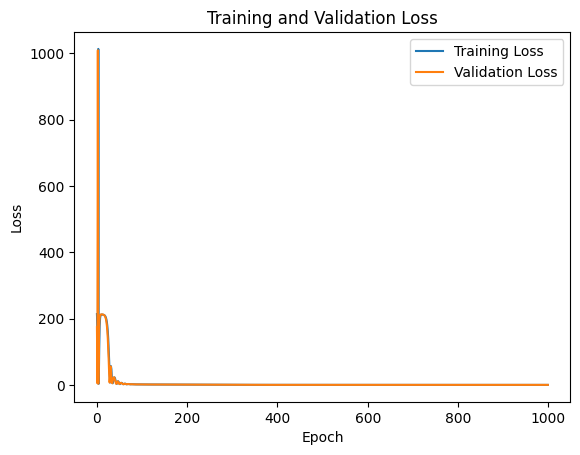

Mean Squared Error: 0.54
Root Mean Squared Error: 0.74
R2 score: 0.61


In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


X_train1=X_train.copy()
X_test1=X_test.copy()
# Normalize the features (standardize them)
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)



# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1).to(device)

# Define the neural network model
class HousePricePredictor(nn.Module):
    def __init__(self, input_dim):
        super(HousePricePredictor, self).__init__()
        self.layer0000 = nn.Linear(input_dim, 4000)

        self.layer000 = nn.Linear(4000, 4000)

        self.layer00 = nn.Linear(4000, 2000)

        self.layer0 = nn.Linear(2000, 1000)
        self.layer1 = nn.Linear(1000, 500)  # First hidden layer
        self.layer2 = nn.Linear(500, 100)         # Second hidden layer
        self.layer3 = nn.Linear(100, 1)          # Output layer (one output for regression)
        
    def forward(self, x):
        x = torch.relu(self.layer0000(x))

        x = torch.relu(self.layer000(x))

        x = torch.relu(self.layer00(x))
        x = torch.relu(self.layer0(x)) 
        x = torch.relu(self.layer1(x))  # ReLU activation for layer 1
        x = torch.relu(self.layer2(x))  # ReLU activation for layer 2
        x = self.layer3(x)              # No activation for output layer (regression)
        return x


# Initialize the model
model = HousePricePredictor(input_dim=X_train.shape[1]).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 1000
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    predictions = model(X_train_tensor)
    loss = criterion(predictions, y_train_tensor)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    # Validation step
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_test_tensor)
        val_loss = criterion(val_predictions, y_test_tensor)
    
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    
    if (epoch + 1) % 100 == 0:  # Print every 10 epochs
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

# Plot the training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Evaluate the model on the test data
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)
    # Use .detach() to get a tensor that doesn't require gradients
    y_pred = y_pred_tensor.detach().cpu().numpy()  # Convert to NumPy array for further processing

# Calculate Mean Squared Error (MSE) and RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)


print(f'Mean Squared Error: {mse:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'R2 score: {r2:.2f}')


X_train=X_train1.copy()
X_test=X_test1.copy()



In [45]:
import numpy as np
import dill
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score




gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    try:
        for device in gpu_devices:
            tf.config.experimental.set_virtual_device_configuration(
                device, [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096*20)]
            )
        print("✅ GPU detected and memory allocated:", gpu_devices)
    except RuntimeError as e:
        print(f"⚠️ GPU Initialization Error: {e}")
else:
    print("⚠️ No GPU detected. Running on CPU.")


np.random.seed(42)
tf.random.set_seed(42)

# ✅ Data Preprocessing
# Assuming `preprocessor` is a scaler or normalizer previously defined (e.g., StandardScaler)
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

# ✅ Get Correct Input Shape
input_dim = X_train_scaled.shape[1]

# ✅ Define Model Function (GPU Optimized)
def build_model(hidden_layer_sizes=(50,), activation='relu', optimizer='adam', alpha=0.0001):
    model = Sequential()
    
    # Input layer
    model.add(Input(shape=(input_dim,)))  # ✅ Explicitly define input shape
    
    # Hidden layers
    for units in hidden_layer_sizes:
        model.add(Dense(units, activation=activation, kernel_regularizer=l2(alpha)))
    
    # Output layer
    model.add(Dense(1, dtype="float32"))  # ✅ Ensure float32 output for stability
    
    # Compile model
    model.compile(optimizer=optimizer, loss='mse')
    
    return model

# ✅ Define Hyperparameter Options (Manual Search)
hidden_layer_options = [(50,), (100,), (50, 50)]
activation_options = ['relu', 'tanh']
optimizer_options = ['adam']#, 'sgd']
alpha_options = [0.0001, 0.001, 0.01]

best_rmse = float("inf")
best_model = None
best_params = None

# ✅ Manual Hyperparameter Search (GPU Execution)
for hidden_layers in hidden_layer_options:
    for activation in activation_options:
        for optimizer in optimizer_options:
            for alpha in alpha_options:
                print(f"Training model with: hidden_layers={hidden_layers}, activation={activation}, optimizer={optimizer}, alpha={alpha}")

                # ✅ Train Model on GPU (TensorFlow automatically selects GPU if available)
                model = build_model(hidden_layers, activation, optimizer, alpha)

                # Train model
                model.fit(X_train_scaled, y_train, epochs=100, batch_size=8, verbose=0)

                # Predict on test set
                y_pred = model.predict(X_test_scaled)

                # Evaluate performance
                mse = mean_squared_error(y_test, y_pred)
                rmse = np.sqrt(mse)
                r2 = r2_score(y_test, y_pred)

                print(f"RMSE: {rmse:.2f}, R2: {r2:.2f}")

                # Save best model
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_model = model
                    best_params = {
                        "hidden_layers": hidden_layers,
                        "activation": activation,
                        "optimizer": optimizer,
                        "alpha": alpha

                    
                }
                    

# ✅ Print Best Parameters
print(f"Best Parameters: {best_params}")
print(f"Best Test RMSE: {best_rmse:.2f}")

# ✅ Save the Best Model
with open('/kaggle/working/neural_network_best_model.pkl', 'wb') as f:
    dill.dump(best_model, f)
print("✅ Model saved successfully with dill.")



✅ GPU detected and memory allocated: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Training model with: hidden_layers=(50,), activation=relu, optimizer=adam, alpha=0.0001
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
RMSE: 0.75, R2: 0.60
Training model with: hidden_layers=(50,), activation=relu, optimizer=adam, alpha=0.001
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
RMSE: 0.76, R2: 0.58
Training model with: hidden_layers=(50,), activation=relu, optimizer=adam, alpha=0.01
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
RMSE: 0.77, R2: 0.57
Training model with: hidden_layers=(50,), activation=tanh, optimizer=adam, alpha=0.0001
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
RMSE: 0.74, R2: 0.60
Training model with: hidden_layers=(50,), activation=tanh, optimizer=adam, alpha=0.001
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
RMSE: 0.76, R2: 0.58
Training model with: hidden_layers=(50,), activation=tanh, optimizer=adam, alpha=0.0

In [46]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import torch

# Check GPU Availability
def is_gpu_available():
    return torch.cuda.is_available()

GPU_AVAILABLE = is_gpu_available()
print(f"GPU Available: {GPU_AVAILABLE}")

# Load Data
df_ = df.copy()

# Preprocessing Pipeline
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns
numerical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])
preprocessor = ColumnTransformer(transformers=[('num', numerical_transformer, numeric_features), ('cat', categorical_transformer, categorical_features)])

# Base Models (GPU-Enabled)
rf = RandomForestRegressor(n_estimators=300, max_depth=20, min_samples_split=5, min_samples_leaf=2, random_state=42)
xgb = XGBRegressor(n_estimators=400, max_depth=10, learning_rate=0.05, tree_method='gpu_hist' if GPU_AVAILABLE else 'hist', random_state=42)
lgb = LGBMRegressor(n_estimators=400, max_depth=-1, learning_rate=0.05, device='gpu' if GPU_AVAILABLE else 'cpu', random_state=42)
cat = CatBoostRegressor(iterations=500, depth=10, learning_rate=0.05, task_type='GPU' if GPU_AVAILABLE else 'CPU', verbose=0, random_state=42)

# Stacking Model
stacking_model = StackingRegressor(
    estimators=[('rf', rf), ('xgb', xgb), ('lgb', lgb), ('cat', cat)],
    final_estimator=GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
)



        
# Pipeline
pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", stacking_model)])

# Train Model
pipeline.fit(X_train, y_train)

# Model Evaluation
y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f"Test RMSE: {rmse:.2f}")
print(f"Test R2 Score: {r2:.2f}")

# Save Model

df = df_.copy()


GPU Available: True


/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 608
[LightGBM] [Info] Number of data points in the train set: 16472, number of used features: 157
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (0.19 MB) transferred to GPU in 0.001150 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 14.539200


/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [17:47:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [17:47:58] WARNING: /workspace/sr

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 586
[LightGBM] [Info] Number of data points in the train set: 13177, number of used features: 146
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (0.15 MB) transferred to GPU in 0.001447 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 14.545519
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 573
[LightGBM] [Info] Number of data points in the train set: 13177, number of used features: 140
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature 

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [17:51:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Test RMSE: 0.70
Test R2 Score: 0.65
